#### Importing Libraries 

In [5]:
import pandas as pd
import shap
from sklearn.linear_model import LogisticRegression
import joblib
import lightgbm as lgb
from sklearn.ensemble import VotingClassifier
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt 
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
import csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import preprocessing
import catboost as catboost
import warnings
from imblearn.over_sampling import SMOTE
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, classification_report, roc_curve

#### Reading, understanding and preprocessing the data 

Detailed comments are mentioned in each cell. To provide a high level overview, in this part of notebook, we are performing missing values imputation, plotting, feature engineering, encoding of categorical columns and oversampling the minority class.

In [6]:
df = pd.read_csv('train_LZdllcl.csv') #reading in the data
df = df.drop(columns = ['employee_id']) #drop employee id

In [7]:
# Missing Value Imputation
df.education.fillna("Bachelor's", inplace=True) #mode is bachelors
df.previous_year_rating.fillna(0, inplace=True) #probably because its a new comer and dont really have a prev yr rating

In [8]:
df.head(3)

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0


In [9]:
df.describe()

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,1.253011,34.803915,3.078748,5.865512,0.351974,0.023172,63.386750,0.085170
std,0.609264,7.660169,1.496458,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,20.000000,0.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,1.000000,29.000000,2.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


In [10]:
df.is_promoted.value_counts() #highly imbalanced data

0    50140
1     4668
Name: is_promoted, dtype: int64

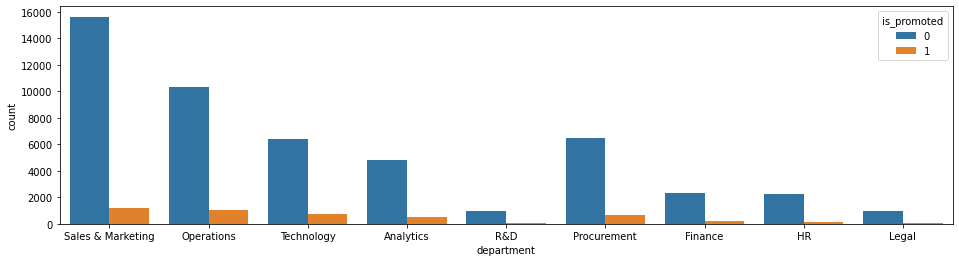

In [11]:
#frequency plot for department 
plt.figure(figsize = (16,4))
ax = sns.countplot(x="department",data=df, hue = "is_promoted")

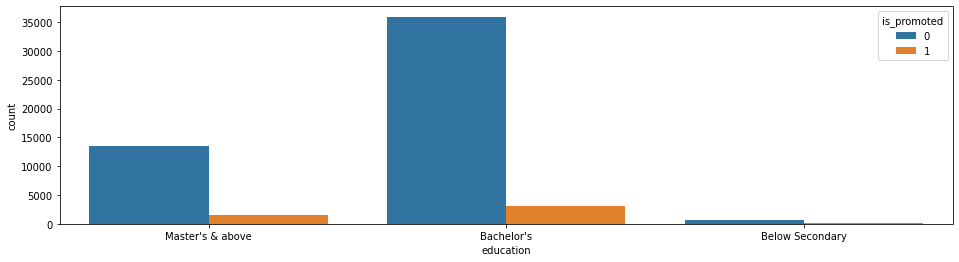

In [12]:
#frequency plot for education 
plt.figure(figsize = (16,4))
ax = sns.countplot(x="education",data=df, hue = "is_promoted")

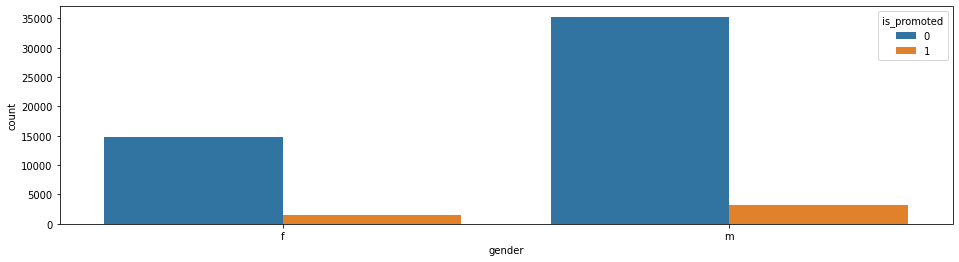

In [13]:
#frequency plot for gender 
plt.figure(figsize = (16,4))
ax = sns.countplot(x="gender",data=df, hue = "is_promoted")

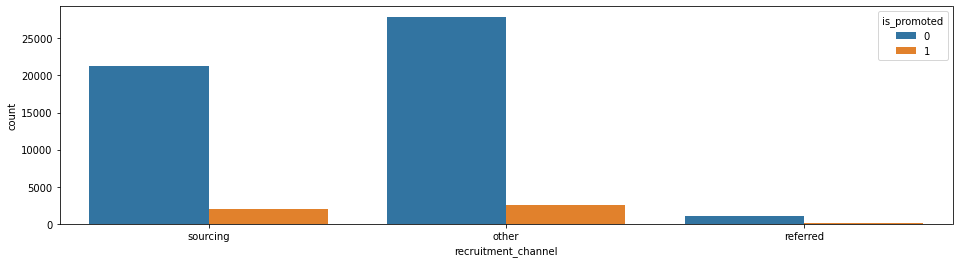

In [14]:
#frequency plot for recruitent_channel 
plt.figure(figsize = (16,4))
ax = sns.countplot(x="recruitment_channel",data=df, hue = "is_promoted")

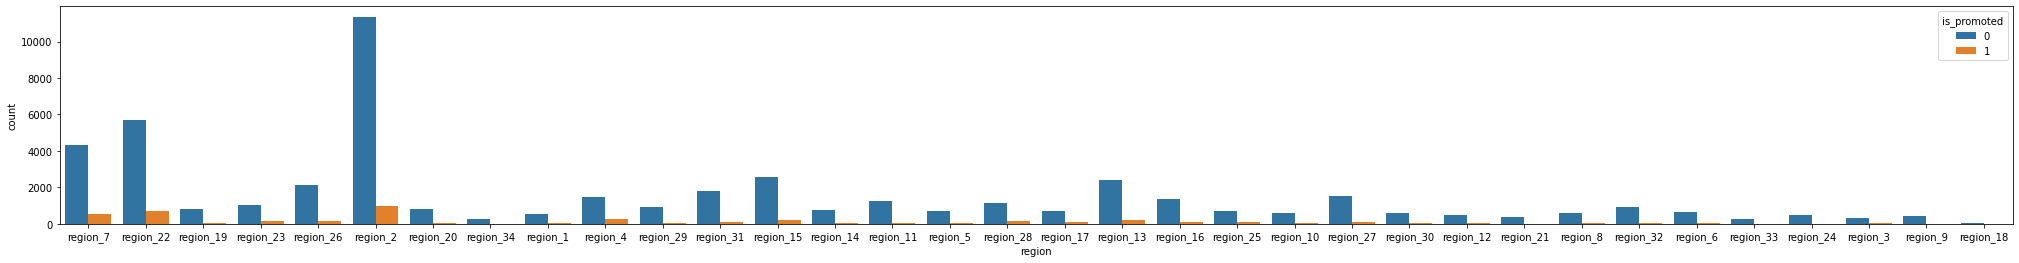

In [15]:
#frequency plot for region 
plt.figure(figsize = (35,4))
ax = sns.countplot(x="region",data=df, hue = "is_promoted")

In [16]:
#generate region_x columns from the region column as 22, 7 and 2 are most appeared regions

def region_22(x):
    if x == 'region_22':
        return 1
    else:
        return 0
def region_2(x):
    if x == 'region_2':
        return 1
    else:
        return 0
def region_7(x):
    if x == 'region_7':
        return 1
    else:
        return 0
    
df['region_region_2'] = df['region'].apply(region_2)
df['region_region_22'] = df['region'].apply(region_22)
df['region_region_7'] = df['region'].apply(region_7)

df = df.drop(columns = ['region'])

In [17]:
#converting categorical columns to numbers
#one hot for department, gender, recruitment_channel
#label for education

categorical_cols = ['department','gender','recruitment_channel'] 
df = pd.get_dummies(df, columns = categorical_cols) #one hot encoding for categorial except education

le = preprocessing.LabelEncoder() #education is ordinal
df['education'] = le.fit_transform(df.education.values)

In [18]:
#creating X as features and y as label
X = df.iloc[:, df.columns!='is_promoted']
y = df['is_promoted']

In [19]:
#SMOTE oversampling the minority class in order to create balance between both classes
smt = SMOTE(sampling_strategy='minority', random_state=0) #oversampling the minority class
X, y = smt.fit_resample(X, y)

In [20]:
#splitting data into train and test set for evaluation before submission
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, random_state=0)

#### Model Building, Tuning, Evaluation and Interpretability

Detailed comments are mentioned in each cell. To provide a high level overview, in this part of notebook, we are performing model training, hyperparameter optimization, models saving, stacking model, model evaluation and model interpretability. 

In [21]:
#Code is commented out because we load in the models from a pickle file instead of retraining. 
#Define model parameters to run and run a Random Search Cross Validation

#model = catboost.CatBoostClassifier(random_state=42)
#parameters = {'depth'         : sp_randInt(4, 10),
#              'learning_rate' : sp_randFloat(),
#              'iterations'    : sp_randInt(10, 100),
#              'random_strength': sp_randFloat(),
#              'border_count': sp_randInt(1, 255),
#              'l2_leaf_reg': sp_randInt(2, 30),
#              'scale_pos_weight': sp_randFloat()
#             }

#model = lgb.LGBMClassifier(random_state=42)
#parameters = {'num_leaves'         : sp_randInt(20, 140),
#              'reg_alpha' : sp_randFloat(),
#              'min_data_in_leaf'    : sp_randInt(30, 500),
#              'lambda_l1': sp_randFloat(),
#              'lambda_l2': sp_randFloat()
#             }

#model = GradientBoostingClassifier(random_state=42)
#parameters = {'max_depth'         : sp_randInt(5, 20),
#              'min_samples_split' : sp_randInt(100, 2000),
#              'min_samples_leaf'    : sp_randInt(30, 80),
#              'max_features': sp_randInt(7, 20),
#              'subsample': sp_randFloat()
#             }

#randm = RandomizedSearchCV(estimator=model, param_distributions = parameters, 
#                           cv = 10, n_iter = 20, n_jobs=-1, random_state=0)
#randm.fit(X_train, y_train)

# Results from Random Search
#print("\n========================================================")
#print(" Results from Random Search " )
#print("========================================================")    

#print("\n The best estimator across ALL searched params:\n",
#      randm.best_estimator_)

#print("\n The best score across ALL searched params:\n",
#      randm.best_score_)

#print("\n The best parameters across ALL searched params:\n",
#      randm.best_params_)

#print("\n ========================================================")

In [22]:
#Code is commented out because we have already made csvs. Csvs contain best set of parameters for each model

#send best parameters to a csv
#with open('catboost_best_parameters.csv', 'w') as f:
#    for key in randm.best_params_.keys():
#        f.write("%s,%s\n"%(key,randm.best_params_[key]))

#send best parameters to a csv
#with open('lightgbm_best_parameters.csv', 'w') as f:
#    for key in randm.best_params_.keys():
#        f.write("%s,%s\n"%(key,randm.best_params_[key]))

#send best parameters to a csv
#with open('gradientboost_best_parameters.csv', 'w') as f:
#    for key in randm.best_params_.keys():
#        f.write("%s,%s\n"%(key,randm.best_params_[key]))

In [23]:
#Code is commented out because we will directly load the model pickle and not parameters. 
#read best parameters from a csv (Add in randm. if training again)

#best_params_ = pd.read_csv('catboost_best_parameters.csv', header=None, index_col=0, squeeze=True).to_dict()
#best_params_ = pd.read_csv('lightgbm_best_parameters.csv', header=None, index_col=0, squeeze=True).to_dict()
#best_params_ = pd.read_csv('gradientboost_best_parameters.csv', header=None, index_col=0, squeeze=True).to_dict()

In [24]:
#Code is commented out because we have already trained and saved models. Using best set of parameters to train respective
#models and then save them using joblib

#depth = best_params_['depth']
#learning_rate = best_params_['learning_rate']
#iterations = best_params_['iterations']
#random_strength = best_params_['random_strength']
#border_count = best_params_['border_count']
#l2_leaf_reg = best_params_['l2_leaf_reg']
#scale_pos_weight = best_params_['scale_pos_weight']

#model = catboost.CatBoostClassifier(depth = depth, learning_rate = learning_rate, iterations = iterations,random_strength = random_strength,border_count = border_count,l2_leaf_reg = l2_leaf_reg,scale_pos_weight = scale_pos_weight, random_state=0);
#model.fit(X_train, y_train, verbose = 0)

# save model
#joblib.dump(model, 'catboost.pkl')

#lambda_l1 = best_params_['lambda_l1']
#lambda_l2 = best_params_['lambda_l2']
#min_data_in_leaf = int(best_params_['min_data_in_leaf'])
#num_leaves = int(best_params_['num_leaves'])
#reg_alpha = best_params_['reg_alpha']

#model = lgb.LGBMClassifier(lambda_l1 = lambda_l1, lambda_l2 = lambda_l2, min_data_in_leaf = min_data_in_leaf,num_leaves = num_leaves,reg_alpha = reg_alpha,random_state=0);
#model.fit(X_train, y_train, verbose = 0)

# save model
#joblib.dump(model, 'lgb.pkl')

#max_depth = best_params_['max_depth']
#min_samples_split = int(best_params_['min_samples_split'])
#min_samples_leaf = int(best_params_['min_samples_leaf'])
#max_features = int(best_params_['max_features'])
#subsample = best_params_['subsample']

#model = GradientBoostingClassifier(max_depth = max_depth, min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf,max_features = max_features,subsample = subsample,random_state=0);
#model.fit(X_train, y_train)

# save model
#joblib.dump(model, 'gb.pkl')



In [25]:
#load all three models again and make a Decision Tree stacking model

#load models
model_gb = joblib.load('gb.pkl')
model_lgb = joblib.load('lgb.pkl')
model_cat = joblib.load('catboost.pkl')

#make predictions on train
pred_gb_train = model_gb.predict(X_train)
pred_lgb_train = model_lgb.predict(X_train)
pred_cat_train = model_cat.predict(X_train)

#make predictions on test
pred_gb_test = model_gb.predict(X_test)
pred_lgb_test = model_lgb.predict(X_test)
pred_cat_test = model_cat.predict(X_test)


#concatenate train predictions into a dataframe
df_train = pd.DataFrame(
    {'gb': pred_gb_train,
     'lgb': pred_lgb_train,
     'cat': pred_cat_train
    })

#concatenate test predictions into a dataframe
df_test = pd.DataFrame(
    {'gb': pred_gb_test,
     'lgb': pred_lgb_test,
     'cat': pred_cat_test
    })

#train a model and compute score
model_stacking = DecisionTreeClassifier(random_state = 0)
model_stacking.fit(df_train,y_train)
model_stacking.score(df_test,y_test)

0.9457518946948544

In [26]:
#load the model you want
model = joblib.load('lgb.pkl')
#model = joblib.load('gb.pkl')
#model = joblib.load('catboost.pkl')

F1 score for test set:  0.9459330434192449
Test Accuracy:  0.9459513362584763
Balanced accuracy test:  0.9458727697554696
Specificity:  0.962286621675268
Sensitivity:  0.9294589178356714


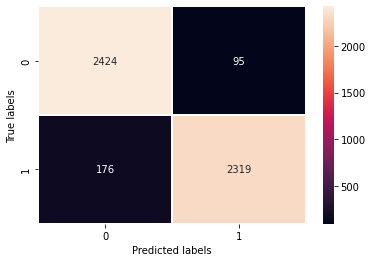

In [27]:
#Print F1 scores, accuracies for test set along with a confusion matrix.
#Note: This is not the test set for competition
y_pred = model.predict(X_test)
print("F1 score for test set: ",f1_score(y_test, y_pred, average='weighted'))
print("Test Accuracy: ",accuracy_score(y_pred,y_test))
print ("Balanced accuracy test: ", balanced_accuracy_score(y_test,y_pred))
##Test cm
ax= plt.subplot()
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt='g', linewidths=1)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
tn, fp, fn, tp = cm.ravel()
print ("Specificity: ",tn / (tn+fp))
print ("Sensitivity: ", tp / (tp+fn))

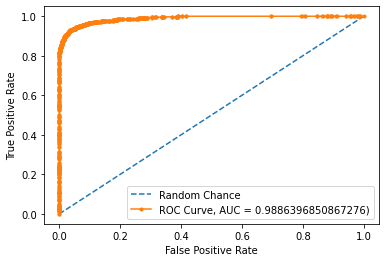

In [28]:
#AUCROC curve

yhat = model.predict_proba(X_test)
pos_probs = yhat[:, 1]
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Chance')
fpr, tpr, _ = roc_curve(y_test, pos_probs)
plt.plot(fpr, tpr, marker='.', label='ROC Curve, AUC = '+str(roc_auc_score(y_test, pos_probs))+')')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

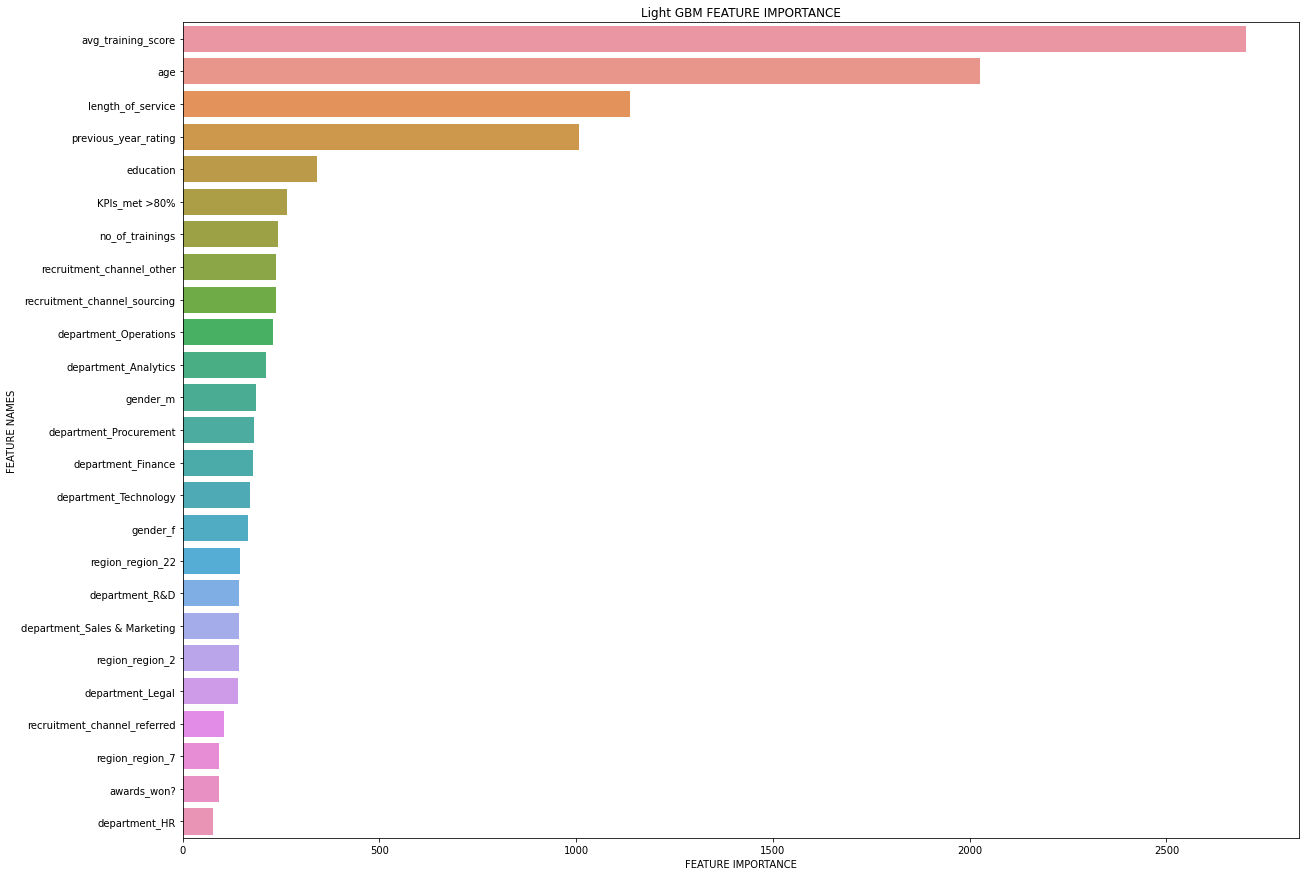

In [29]:
#a plot of feature importances

def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(20,15))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
#plot_feature_importance(model.get_feature_importance(),df.drop(columns = ['is_promoted']).columns,'CATBOOST')
plot_feature_importance(model.feature_importances_,df.drop(columns = ['is_promoted']).columns,'Light GBM')

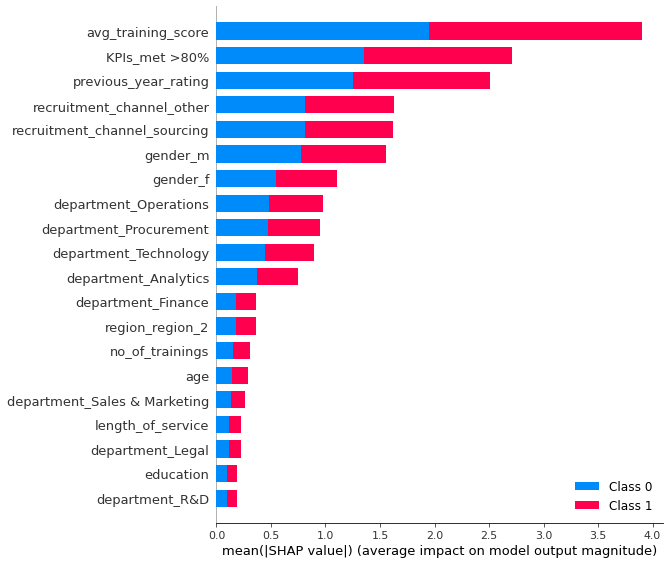

In [30]:
#Model Interpretability using SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns)

#### Submission Results

Detailed comments are mentioned in each cell. To provide a high level overview, in this part of notebook, we are generating predictions on the test set that is used for competition scoring using individual models and ensemble techniques.

In [32]:
#read in the test data and perform the same transformations as we did previously on official train set

df_test_unm = pd.read_csv('test_2umaH9m.csv')
df_test = pd.read_csv('test_2umaH9m.csv')
df_test.education.fillna("Bachelor's", inplace=True) #mode is bachelors
df_test.previous_year_rating.fillna(0, inplace=True) #0 is just joined
df_test = df_test.drop(columns = ['employee_id'])

df_test['region_region_2'] = df_test['region'].apply(region_2)
df_test['region_region_22'] = df_test['region'].apply(region_22)
df_test['region_region_7'] = df_test['region'].apply(region_7)

df_test = df_test.drop(columns = ['region'])
df_test = pd.get_dummies(df_test, columns = categorical_cols)
df_test['education'] = le.fit_transform(df_test.education.values)

In [34]:
#load all models. 
#choose if you want to do hard voting, soft voting or stacking and uncomment code accordingly

model_gb = joblib.load('gb.pkl')
model_lgb = joblib.load('lgb.pkl')
model_cat = joblib.load('catboost.pkl')

model = VotingClassifier(estimators=[('gb', model_gb), ('lgb', model_lgb),('cat', model_cat)], voting='hard')
model.fit(X_train,y_train)

#model = VotingClassifier(estimators=[('gb', model_gb), ('lgb', model_lgb),('cat', model_cat)], voting='soft')
#model.fit(X_train,y_train)


#X_test = df_test.values
#pred_gb_test = model_gb.predict(X_test)
#pred_lgb_test = model_lgb.predict(X_test)
#pred_cat_test = model_cat.predict(X_test)
#df_test = pd.DataFrame(
#    {'gb': pred_gb_test,
#     'lgb': pred_lgb_test,
#     'cat': pred_cat_test
#    })

0:	learn: 0.3889984	total: 85.3ms	remaining: 5.8s
1:	learn: 0.3066427	total: 119ms	remaining: 4s
2:	learn: 0.2450945	total: 155ms	remaining: 3.4s
3:	learn: 0.1973059	total: 190ms	remaining: 3.09s
4:	learn: 0.1827142	total: 224ms	remaining: 2.87s
5:	learn: 0.1724438	total: 258ms	remaining: 2.71s
6:	learn: 0.1694250	total: 297ms	remaining: 2.63s
7:	learn: 0.1636363	total: 331ms	remaining: 2.52s
8:	learn: 0.1568481	total: 366ms	remaining: 2.44s
9:	learn: 0.1543391	total: 403ms	remaining: 2.38s
10:	learn: 0.1505310	total: 439ms	remaining: 2.31s
11:	learn: 0.1475330	total: 477ms	remaining: 2.27s
12:	learn: 0.1465571	total: 519ms	remaining: 2.23s
13:	learn: 0.1443592	total: 554ms	remaining: 2.18s
14:	learn: 0.1413784	total: 591ms	remaining: 2.13s
15:	learn: 0.1392720	total: 631ms	remaining: 2.09s
16:	learn: 0.1374350	total: 672ms	remaining: 2.06s
17:	learn: 0.1357569	total: 707ms	remaining: 2s
18:	learn: 0.1346300	total: 749ms	remaining: 1.97s
19:	learn: 0.1331119	total: 785ms	remaining: 1.9

VotingClassifier(estimators=[('gb',
                              GradientBoostingClassifier(max_depth=17.0,
                                                         max_features=16,
                                                         min_samples_leaf=72,
                                                         min_samples_split=184,
                                                         random_state=0,
                                                         subsample=0.634274057957335)),
                             ('lgb',
                              LGBMClassifier(lambda_l1=0.2726562945801132,
                                             lambda_l2=0.4776651173213498,
                                             min_data_in_leaf=69,
                                             num_leaves=107, random_state=0,
                                             reg_alpha=0.4799771723750573)),
                             ('cat',
                              <catboost.core.CatBoostC

In [35]:
#generate a final set of predictions
X_test = df_test.values
y_pred = model.predict(X_test)
df_test_unm['is_promoted'] = y_pred
df_test_unm[['employee_id','is_promoted']].to_csv('hard_predictions.csv', index=None)